<a href="https://colab.research.google.com/github/tiwarylab/af2rave/blob/notebooks/notebooks/Tutorial_1_data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# af2rave Colab installation

Note: this installation is for colab use only.


Warning: After running the following cell, the kernel will crash and reset due to the conda environment. The pop-up stating the session has crashed can be ignored. The rest of the notebook can then be run **(only after this installation cell has finished running)**.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -q pdbfixer mdtraj openmm
!git clone https://github.com/tiwarylab/af2rave.git
!pip install af2rave/

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mdtraj
    - openmm
    - pdbfixer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.6               |       he440d0b_1          47 KB  conda-forge
    c-blosc2-2.16.0            |       h3122c55_0         335 KB  conda-forge
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    cud

# Colabfold installation

In [ ]:
#@title colabfold dependencies ------ check
%%time
from google.colab import files
import os
import re
import hashlib
import random

!mkdir colabfold
%cd /content/colabfold

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

USE_AMBER = False
USE_TEMPLATES = "none"
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

mkdir: cannot create directory ‘colabfold’: File exists
/content/colabfold
CPU times: user 2.19 ms, sys: 1.74 ms, total: 3.93 ms
Wall time: 104 ms


In [ ]:
#@title mounting google drive --- maybe not necessary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Notebook pipeline

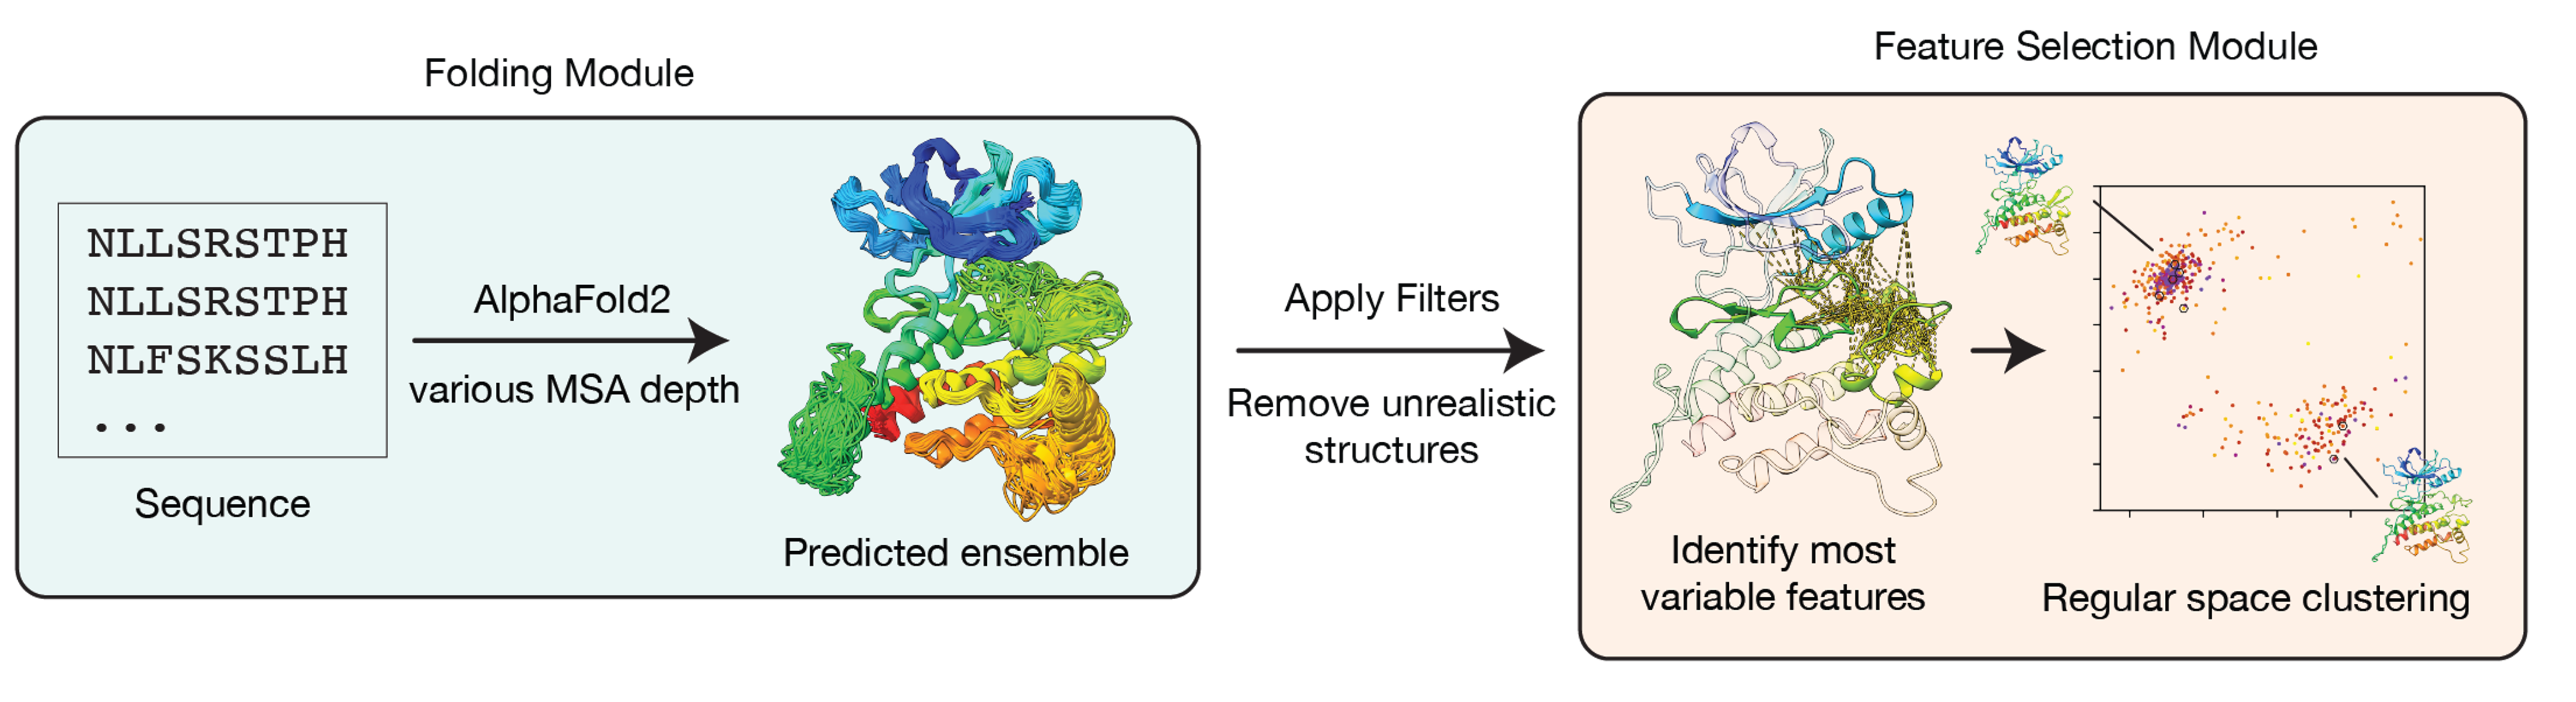

This tutorial notebook follows the first two parts of the pipeline as described in [the preprint](https://chemrxiv.org/engage/chemrxiv/article-details/67a3bf5f81d2151a024c36cc). It goes through rMSA predictions, feature selection and filtering, and creating and saving the simulation box. We use DDR1 as our sample system.  

The notebook is broken down into sections where the first line typically imports the `af2rave` class necessary to run the cells that follow. Here, we first import a few packages that are used throughout the notebook.

In [ ]:
import glob
from natsort import natsorted

import numpy as np
import matplotlib.pyplot as plt

# colabfold: rMSA predictions

Before using the package, we generate rMSA predictions using colabfold. For demonstration purposes, the MSA parameters are defaulted to low values. Work using DDR1 had `max_msa = 8:16` and `num_seeds = 128` to produce 640 structures.

After running the prediction cell, the results will be saved in a zipped file: `structures.zip`

Note: this part of the notebook will run the longest depending on parameters used.

In [ ]:
#@title Input protein sequence(s) and MSA parameters
%cd /content/colabfold

query_sequence = 'GPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
max_msa = "4:8" #@param ["1024:2048", "512:1024", "256:512","128:256", "64:128", "32:64", "16:32","8:16","4:8", "2:4","1:2"]
#@markdown  - Choose `max_msa_cluster:max_extra_msa` to reduce the length of MSA used in initialization of AF2 (prescribed 16:32 and/or 8:16)
num_seeds = 4 #@param [4,8,16,32,64,128] {type:"raw"}
#@markdown  - For a `num_seeds` value rMSA give `num_seeds*5` structures (prescribed 128)
msa_mode = "mmseqs2" #@param ["mmseqs2", "no_msa","custom"]
#@markdown  - Choose the type of MSA input `[mmseqs2, custom, no msa]`

# Initializations and creating working dir
jobname = 'test'
custom_template_path = None
use_templates = False
pair_mode = "unpaired_paired"
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
model_type = "auto"
num_recycles = 1
recycle_early_stop_tolerance = None
relax_max_iterations = 200
pairing_strategy = "greedy"
use_dropout = True
save_all = True
save_recycles = False
save_to_google_drive = False
dpi = 200
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]
jobname = add_hash(basejobname, query_sequence)
# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"
os.makedirs(jobname, exist_ok=True)

#save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# MSA decision
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



/content/colabfold
sequence GPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV
length 315


2025-02-19 17:15:42,522 Running on GPU
2025-02-19 17:15:42,704 Found 4 citations for tools or databases
2025-02-19 17:15:42,705 Query 1/1: test_50d84_1 (length 315)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


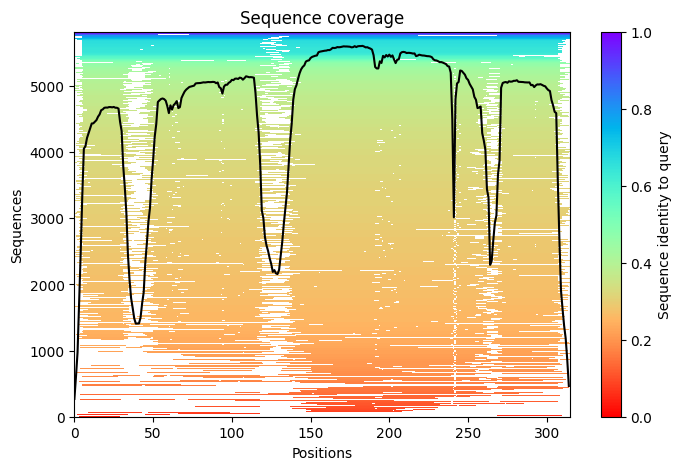

2025-02-19 17:15:45,512 Setting max_seq=4, max_extra_seq=8
2025-02-19 17:16:30,299 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=34.4 pTM=0.313
2025-02-19 17:16:39,827 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=44.7 pTM=0.428 tol=9.76
2025-02-19 17:16:39,828 alphafold2_ptm_model_1_seed_000 took 38.3s (1 recycles)
2025-02-19 17:16:49,762 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=37.8 pTM=0.275
2025-02-19 17:16:59,218 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=42.1 pTM=0.33 tol=8.09
2025-02-19 17:16:59,219 alphafold2_ptm_model_2_seed_000 took 19.1s (1 recycles)
2025-02-19 17:17:08,970 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=25.5 pTM=0.385
2025-02-19 17:17:18,714 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=34.7 pTM=0.243 tol=14.2
2025-02-19 17:17:18,715 alphafold2_ptm_model_3_seed_000 took 19.3s (1 recycles)
2025-02-19 17:17:28,718 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=53.7 pTM=0.473
2025-02-19 17:17:38,492 alphafold2_ptm_model_4_seed_000 recycle=1 

In [ ]:
#@title Run Prediction
display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2


try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path

def input_features_callback(input_features):
  plot_msa_v2(input_features)
  plt.show()
  plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if False:
    fig = plot_protein(protein_obj, Ls=length, dpi=150)
    plt.show()
    plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True
num_relax=0
download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)


## save the results
os.chdir('/content/colabfold/')
if not os.path.isdir('/content/structures'):
  os.mkdir('/content/structures')
else:
  print('Already exists!!!')
  os.system('mv /content/structures /content/backup')
  os.mkdir('/content/structures')

for i in range(num_seeds*5):
  tag = results["rank"][0][i]
  jobname_prefix = ".custom" if msa_mode == "custom" else ""
  pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
  json_filename = f"{jobname}/{jobname}{jobname_prefix}_scores_{tag}.json"
  os.system(f'cp {pdb_filename} /content/structures/pred_{i+1}.pdb')
  os.system(f'cp {json_filename} /content/structures/pred_{i+1}.json')
os.system(f'cp {jobname}/config.json /content/structures/.')
os.system(f'cp {jobname}/{jobname}.a3m /content/structures/msa.a3m')
os.system(f'rm -r {jobname}')
os.chdir('/content/')
os.system('zip -r structures.zip structures')

print('All structures are saved in `/content/structures.zip`')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

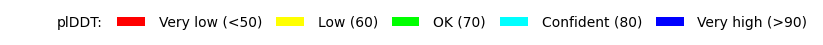

In [ ]:
#@title 3D structure (unrelaxed) {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

pdb_filename = f"/content/structures/pred_{rank_num}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

# Feature Selection

This section ranks the pairwise distances as potential features according to their coefficient of variance.

In [ ]:
import af2rave.feature as af2feature
plt.rcParams.update({'font.size': 30})

###  Structure filtering

First, we read the PDB files generated by colabfold and create an instance.

Note: you can upload structures as well as use the dataset provided in the `af2rave` repo


```
pdb_dir = f"af2rave/datasets/DDR1_MSA8/"
pdb_files = natsorted(glob.glob(f"{pdb_dir}/*.pdb"))
```



In [ ]:
pdb_files = natsorted(glob.glob(f"structures/*.pdb"))
rMSA = af2feature.FeatureSelection(pdb_files)

We then compute the RMSD of each structure compared to the highest pLDDT structure. The default cutoff is 10 Å.

Note: If using DDR1 repo data, we use a 6 Å cutoff here.

If the structure has very flexible ends (terminals), the RMSD distribution will be long-tailed and largely depends on the conformation of these flexible ends. It is recommended that these tails be removed in AF2 calculations.

Here, we use only an RMSD filter but others can be added as AlphaFold2 can sometimes generate unrealistic structures with too long or short peptide bonds as well as some with overlapping van der Waals radii.

Currently, these two additional filters can be implemented with `af2rave`:


```
peptide_mask = rMSA.peptide_bond_filter(mean_cutoff=1.4, std_cutoff=0.2)
rMSA.apply_filter(peptide_mask)

steric_clash_mask = rMSA.steric_clash_filter(min_non_bonded_cutoff=1.0)
rMSA.apply_filter(steric_clash_mask)

```




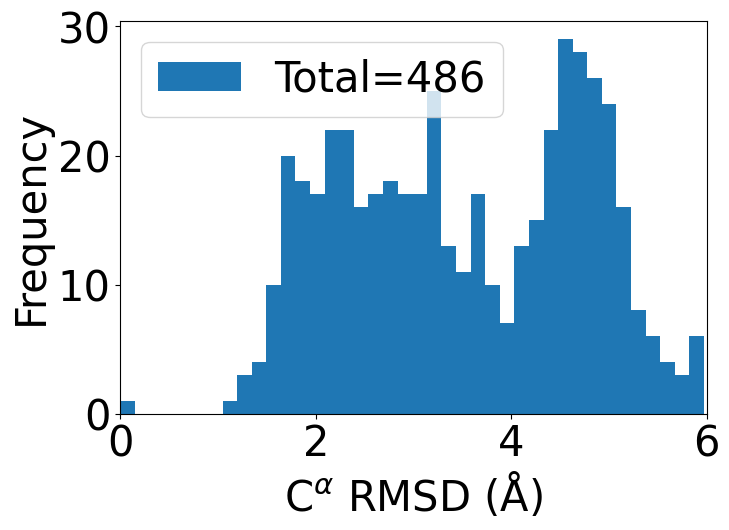

In [ ]:
rmsd_cutoff = 10 # Angstrom

mask = rMSA.rmsd_filter(selection="name CA", rmsd_cutoff=rmsd_cutoff)
rMSA.apply_filter(mask)

rmsd = np.asarray([r for r in rMSA.get_rmsd().values()])

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
_ = ax.hist(rmsd, bins=40, label=f"Total={rmsd.shape[0]}")
ax.set_xlabel(r"C$^\alpha$ RMSD (Å)")
ax.set_ylabel("Frequency")
ax.set_xlim(0, rmsd_cutoff)
ax.legend()

### Compute and rank pairwise distances

Next, we choose a subset of atoms and use them to construct pairwise distances. These distances will be ranked according to their coefficient of variance and the top `n_features` will be selected as a feature. This is a very crude selection, feel free to include more.

The choice of `atom_set` can be all CA atoms, but here is where your prior knowledge about a particular system may help. If you know good features or important atoms, include them in the list.

The plot will be a histogram of the CoVs for the pairwise distance between all these selected atoms and the cutoff.

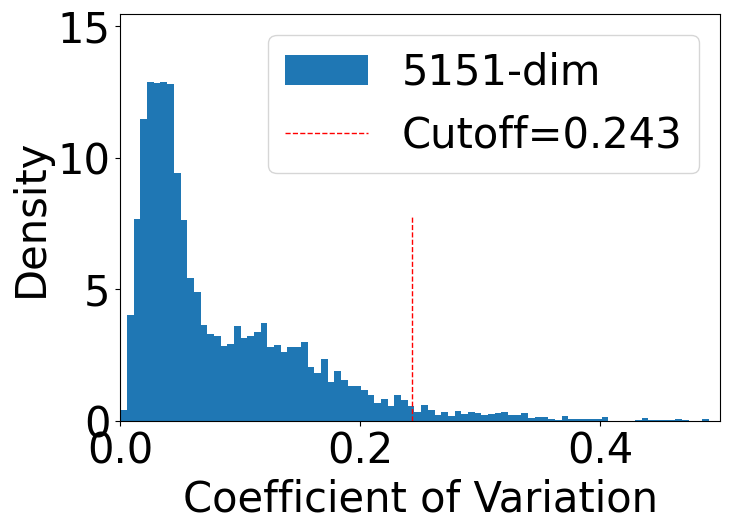

In [ ]:
n_features = 200
atom_set = ["resid 52 to 81 and name CA",
            "resid 162 to 224 and name CA",
            "resid 185 and name CB CG",    # DFG-Asp
            "resid 186 and name CZ CG",    # DFG-Phe
            "resid 187 and name O",        # DFG-Gly
            "resid 73 and name CD",        # ChelE
            "resid 56 and name CB CZ NZ",  # SB-K
            "resid 171 and name N"         # SB-R
            ]

selection = " or ".join([f"({atom})" for atom in atom_set])
names, cv = rMSA.rank_feature(selection=selection)

fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

counts, _, _ = ax.hist(cv, bins=100, label=f"{len(names)}-dim", density=True)
cv_cutoff = cv[n_features]
ax.vlines(cv_cutoff, 0, np.max(counts)*0.6, color="red", linestyle="--", linewidth=1, label=f"Cutoff={cv_cutoff:.3f}")

ax.set_ylim(0, np.max(counts)*1.2)
ax.set_xlabel("Coefficient of Variation")
ax.set_ylabel("Density")
ax.set_xlim(0, 0.5)
ax.legend()

### Regular space clustering and PCA projection

We can then identify cluster centers from a subset of the 200 most variable features. This number is chosen to provide meaningful features that can otherwise be missed if too small or insignificant if too big.

The `min_dist` parameter is a distance threshold in angstroms that controls the number of cluster centers identified, a lower one would mean more clusters.

In [ ]:
center_id = rMSA.regular_space_clustering(names[:200], min_dist=5)
print(f"{center_id.shape[0]} clusters identified.")

for i in center_id:
    print(rMSA.pdb_name[i])

9 clusters identified.
af2rave/datasets/DDR1_MSA8/pred_1.pdb
af2rave/datasets/DDR1_MSA8/pred_47.pdb
af2rave/datasets/DDR1_MSA8/pred_209.pdb
af2rave/datasets/DDR1_MSA8/pred_292.pdb
af2rave/datasets/DDR1_MSA8/pred_26.pdb
af2rave/datasets/DDR1_MSA8/pred_176.pdb
af2rave/datasets/DDR1_MSA8/pred_333.pdb
af2rave/datasets/DDR1_MSA8/pred_137.pdb
af2rave/datasets/DDR1_MSA8/pred_391.pdb


We can visualize these results in PC space as well as the more interpretable Dunbrack space. The structures outlined in bold hexagons are those to be used in MD simulations.

Text(0, 0.5, 'PC2')

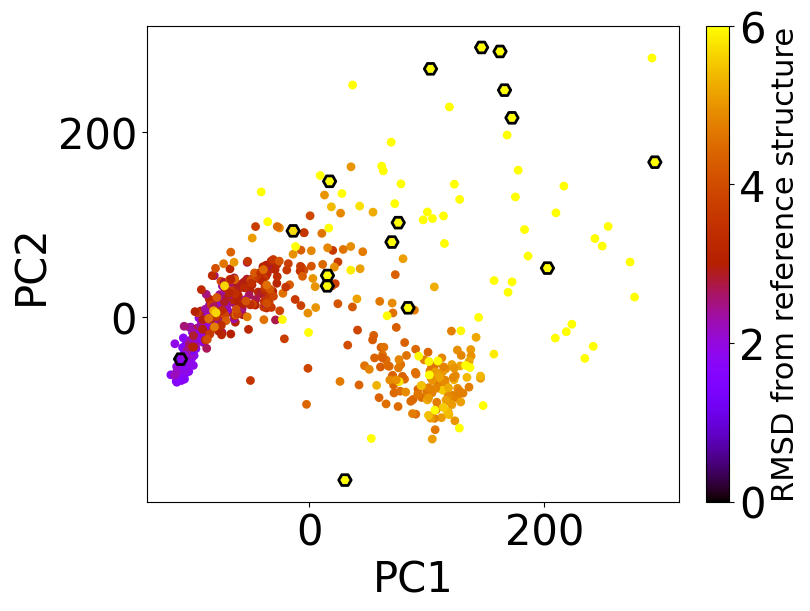

In [ ]:
# Configuations for PCA
components = 2
pca, pca_result = rMSA.pca(n_components=components)

fig, ax = plt.subplots(figsize=(8, 6), layout='compressed')

im = ax.scatter(pca_result[:,0], pca_result[:,1], s=40, c=rmsd, cmap="gnuplot", norm="linear", edgecolors="none", vmin=0.0, vmax=6.0)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label("RMSD from reference structure", fontsize=22)

# cluster center in PC space
pca_cc = pca.transform(rMSA.feature_array[center_id])
ax.scatter(pca_cc[:,0], pca_cc[:,1], s=80, edgecolor="k", marker="H", facecolor="None", linewidth=2)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

Text(0, 0.5, '$D_2 = \\beta$3-Lys-C$\\alpha$/DFG-Phe-C$\\zeta$ (Å)')

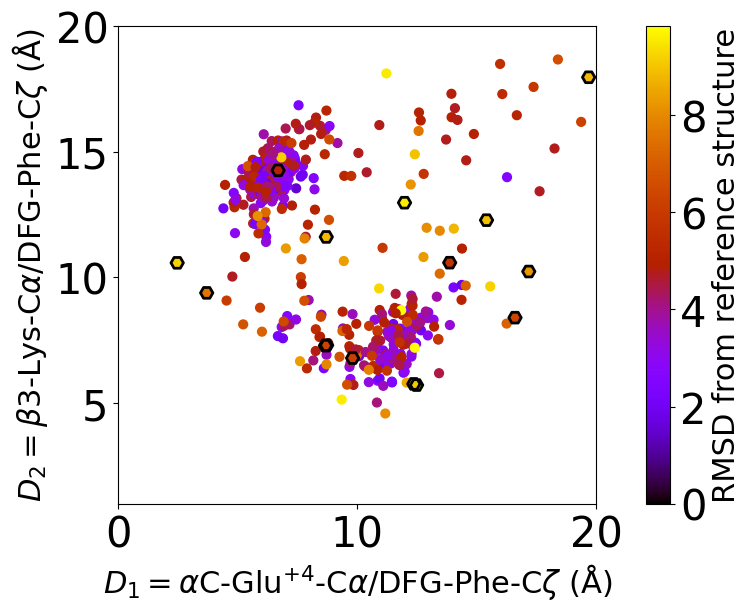

In [ ]:
d1 = rMSA.features["MET78A-CA-PHE187A-CZ"]
d2 = rMSA.features["LYS57A-CA-PHE187A-CZ"]

fig, ax = plt.subplots(figsize=(8,6), layout='compressed')
ax.set_box_aspect(1)
ax.set_xlim(0, 20)
ax.set_ylim(1, 20)

im = ax.scatter(d1, d2, s=40, c=rmsd, cmap="gnuplot")
ax.scatter(d1[center_id], d2[center_id], s=80, edgecolor="k", marker="H", facecolor="None", linewidth=2)

cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label("RMSD from reference structure", fontsize=22)

ax.set_xlabel(r"$D_1 = \alpha$C-Glu$^{+4}$-C$\alpha$/DFG-Phe-C$\zeta$ (Å)", fontsize=22)
ax.set_ylabel(r"$D_2 = \beta$3-Lys-C$\alpha$/DFG-Phe-C$\zeta$ (Å)", fontsize=22)

(0.0, 1.0)

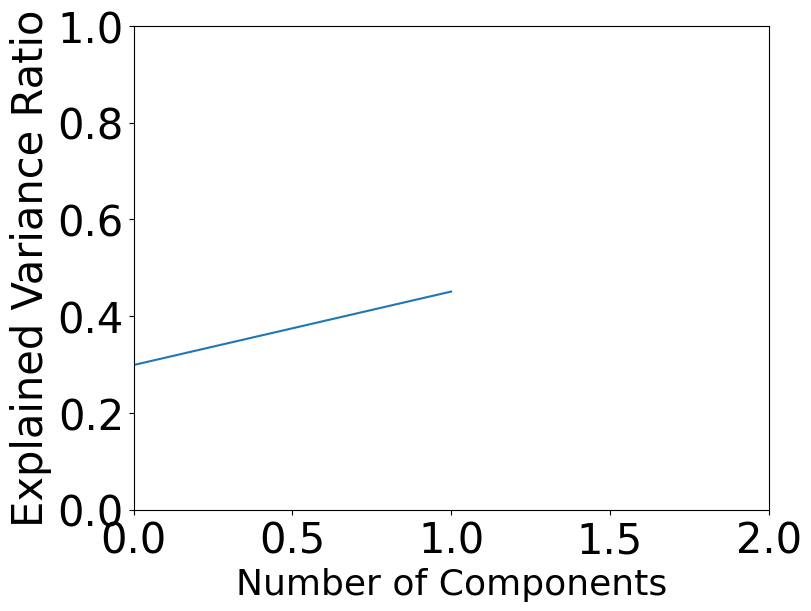

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), layout='compressed')
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("Number of Components", fontsize=26)
ax.set_ylabel("Explained Variance Ratio", fontsize=30)
ax.set_xlim(0, components)
ax.set_ylim(0, 1)

# Creating a simulation box

In [ ]:
import af2rave.simulation as af2sim

From the clusters identified, we can create the simulation box necessary to run MD. For a single cluster, an MD structure can be generated in the following way:


```
pdb0 = rMSA.pdb_name[center_id[0]] # first cluster

box = af2sim.SimulationBox(pdb0)
box.create_box()
box.save_pdb(f"boxed_example.pdb")
```

`create_box()` takes care of solvation and can be customized further

The following script generates PDBs for all cluster centers.

To run MD simulations, pairwise distance CVs are also necessary. These can be viewed by:

```
print([tuple(rMSA.atom_pairs[n]) for n in names])
```
where `atom_pairs` are the original PDB atom indices. With the creation of the simulation box, the indices shift and function `map_atom_index` translates them. We then save the top 200 features in `index.npy`.


In [ ]:
index = None
pdb_names = [rMSA.pdb_name[i] for i in center_id]

for i in pdb_names:
    prefix = i.split("/")[-1]
    box = af2sim.SimulationBox(i)
    box.create_box()
    box.save_pdb(f"boxed_{prefix}")


    new_index = box.map_atom_index([tuple(rMSA.atom_pairs[n]) for n in names[:200]])
    if index is None:
        index = new_index
        np.save("index.npy", index)
    else:
        assert np.equal(index, new_index).all()